# RoboGarden ML Capstone Project - Credit Card Fraud Detection (Part B)

## Reduced Set of Features and Undersampling.  

### Eight classifiers were tested in Part A.  Dataset analysis and visualization is included in Part A.  Dataset preparation will be duplicated but not explained.

## *This Project is the course completion submission for the RoboGarden Professional DataScience & Machine Learning Bootcamp.   July 2019*    

## *Objective:  Detect fraudulent credit card transactions based on transaction history.*

### *This is an update of the project with data visualization and classifier optimization on all data features except for time.   Autoencoders is in Part C.*

## Information:
Description: The dataset consists 284,807 credit card transactions made by European cardholders in September 2013

* Link: https://data.world/raghu543/credit-card-fraud-data

* File: creditcard.csv

* Features: 
    * Time (integer): transaction time (seconds since first transaction)  
    * V1 – V28 (decimal): results of PCA transformation  
    * Amount (decimal): transaction amount  
    * Class (T/F): fraudulent/genuine transaction (target)
* Notes:
    * Feature V1-V28 are the principal components obtained with PCA
    * The original features and background information about the data are not provided due to confidentiality issues
* License: Public domain (CC0)

In [1]:
#Import General Libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import livelossplot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
# Load Data
dataset = pd.read_csv('creditcard.csv')

In [3]:
dataset.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,False
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,False
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,False
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,False
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,False


In [4]:
dataset['class'].value_counts()

False    284315
True        492
Name: class, dtype: int64

In [5]:
# Drop Duplicates
df = dataset.drop_duplicates()
df['class'].value_counts()

False    283253
True        473
Name: class, dtype: int64

In [6]:
# ReIndex df so that there are no missing index values
df.index=range(df.shape[0])

## *Start with the complete set, drop the 'time' feature and split into train & test subsets and preserve the ratio of fraudulent samples in both using "stratify" in train_test_split.*  

In [7]:
y = df['class']
y.shape

(283726,)

In [8]:
dfx = df.drop(['time','class'], axis = 1)
dfx.shape

(283726, 29)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(dfx,y, stratify = y, test_size = 0.25, random_state = 6)

In [10]:
y_train.value_counts()

False    212439
True        355
Name: class, dtype: int64

In [11]:
y_test.value_counts()

False    70814
True       118
Name: class, dtype: int64

### Retain number of positives & negatives from train & test sets for use in calculating classification counts for changing decision thresholds.

In [12]:
N, P = y_test.value_counts()
Ntr, Ptr = y_train.value_counts()
N, P, Ntr, Ptr

(70814, 118, 212439, 355)

In [13]:
Test_Set = x_test  # Reserve a copy of x_test that is not scaled so that the actual amounts can be referenced

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

### The test and train sets are complete and cover the entire population and are balanced with an equal proportion of fraud samples in each set.
#  

## Prepare functions for plots and reports

In [15]:
def Prob_Hist(model_name,probs):
    plt.figure(figsize=(12,4)) 
    sns.distplot(probs[:,1], bins = 100, color = 'tab:red', label = 'Sample Probability ', kde = False)
    plt.title((('Histogram of Prediction Probability for {}').format(model_name)), weight = 'bold', fontsize = 16)
    plt.xlabel('Classifier Probability', fontsize = 14)
    plt.ylabel( 'Log No. of Samples')
    plt.yscale('log')
    plt.legend()
    plt.show()

In [140]:
def ROC_Plot(model_name, y_test, y_pred, probs, P, N):

    fpr_, tpr_, thresholds_ = roc_curve(y_test, probs[:,1])
    roc_auc = auc(fpr_, tpr_)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    
    plt.title((('{}\nReceiver Operating Characteristic').format(model_name)), weight = 'bold', fontsize = 16)
    plt.plot(fpr_, tpr_, 'purple', lw = '3', label='ROCAUC = %0.2f'% roc_auc)
    plt.scatter(fpr[1], tpr[1],s = 100, c = 'r', label = ('Conf. Matrix {:0.1e}, {:0.2f}').format(fpr[1], tpr[1]))
    plt.plot([0,1],[0,1],'r--')
    
    plt.legend(loc='lower right', fontsize = 14)
    plt.xlim([-0.01,1.01])
    plt.ylim([-0.0,1.01])
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.ylabel('True Positive Rate', weight = 'bold', fontsize = 14)
    plt.xlabel('False Positive Rate', weight = 'bold', fontsize = 14)
    plt.grid('black')

    return fpr_, tpr_, thresholds_

In [141]:
def PRC_Plot(model_name, y_test, y_pred, probs, P, N):

    precision_, recall_, _ = precision_recall_curve(y_test, probs[:,1])
    AP = average_precision_score(y_test, probs[:,1])
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    single_pt_recall = tpr[1]
    single_pt_precision = (tpr[1]*P)/(tpr[1]*P + fpr[1]*N)
    
    plt.title((('{}\nPrecision - Recall Curve').format(model_name)), weight = 'bold', fontsize = 16)
    plt.step(recall_, precision_, 'blue', lw = '3', where = 'pre', label='au_prc = %0.2f'% AP)
    plt.scatter(single_pt_recall, single_pt_precision, s = 100, c = 'r', label = ('Conf. Matrix: {:0.2f}, {:0.2f}').format(single_pt_recall, single_pt_precision))
      
    plt.legend(loc='lower left', fontsize = 14)
    plt.xlim([-0.01,1.01])
    plt.ylim([-0.0,1.01])
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.ylabel('Precision', weight = 'bold', fontsize = 14)
    plt.xlabel('Recall', weight = 'bold', fontsize = 14)
    plt.grid('black')

    return

In [143]:
def Det_Amt_PLot(model_name, Test_set, y_test, y_pred):
    # Calculate the amount of fraud detected, missed, and false positive
    fraud_amount_IDd = Test_set

    fraud_amount_IDd['TP'] = 0
    fraud_amount_IDd['FP'] = 0
    fraud_amount_IDd['FN'] = 0
    
    fraud_amount_IDd['pred'] = y_pred
    fraud_amount_IDd['ytest'] = y_test
    
    fraud_amount_IDd['TP'] = fraud_amount_IDd['pred'] * fraud_amount_IDd['ytest']
    fraud_amount_IDd['FP'] = fraud_amount_IDd['pred'] * (fraud_amount_IDd['ytest'] == 0)
    fraud_amount_IDd['FN'] = (fraud_amount_IDd['pred'] == 0) * fraud_amount_IDd['ytest']

    fraud_amount_IDd['fraudIDd'] = fraud_amount_IDd['amount'] * fraud_amount_IDd['TP']
    fraud_amount_IDd['False_+ve'] = fraud_amount_IDd['amount'] *fraud_amount_IDd['FP']
    fraud_amount_IDd['fraud_notIDd'] = fraud_amount_IDd['amount'] * fraud_amount_IDd['FN']
    
    # PLot histogram of fraud detected, missed, and false positives
    plt.figure(figsize=(12,4))
    sns.distplot(fraud_amount_IDd['fraudIDd'][fraud_amount_IDd['TP'] == 1], bins = 40, color = 'tab:blue', label = 'Fraud Identified', kde = False) 
    sns.distplot(fraud_amount_IDd['fraud_notIDd'][fraud_amount_IDd['FN'] == 1], bins = 40, color = 'tab:orange', label = 'False -ve', kde = False)
    sns.distplot(fraud_amount_IDd['False_+ve'][fraud_amount_IDd['FP'] == 1], bins = 40, color = 'tab:red', label = 'False +ve', kde = False)
    
    plt.title((('Histogram of FP, TP, & FN Amounts for {}').format(model_name)), weight = 'bold', fontsize = 16)
    plt.xlabel('Amount', fontsize = 14)
    plt.yscale('log')
    plt.legend()
    plt.show()
    
    # Print Sums
    fraudIDd = fraud_amount_IDd['fraudIDd'].sum()
    fraud_notIDd = fraud_amount_IDd['fraud_notIDd'].sum()
    false_pos_total = fraud_amount_IDd['False_+ve'].sum()
    print(('Fraud total identified is {:.{prec}f},\nFraud total missed is {:.{prec}f},\nNormal total misclassified is {:.{prec}f}').format(fraudIDd,fraud_notIDd, false_pos_total, prec = 2))

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from time import time

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, f1_score
from inspect import signature

In [33]:
def Conf_Matrix(_title, cm):
    sns.set(font_scale=1.4)
    plt.title(('{}\n Confusion Matrix').format(_title))
    c_map = ['blue',  'orange']
    sns.heatmap(cm, cmap = c_map,  annot=True, fmt = 'g', annot_kws={"size": 24, "weight": 'bold'})
    plt.xlabel('Normal                  Fraud\nPredicted')
    plt.ylabel('Actual\n Fraud            Normal')
    
    return

In [137]:
# PLot for True Positive Counts vs. Decision Threshold
def FP_TP_Count_vs_Threshold(model_name, fpr_, tpr_, thresholds_, P, N, ylim, DT):
    plt.step(thresholds_, tpr_*P, c='blue', lw = '3', where = 'mid', label = 'True +ve')
    plt.step(thresholds_, fpr_*N, c='orange', lw = '3', where = 'mid', label = 'False +ve')
    plt.plot([DT,DT],[0,ylim], 'r--')
    plt.ylim(-0.01, ylim)
    plt.xlim(-0.01, 1.01)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.title(('{}\n FP & TP Count vs. Decision Threshold').format(model_name), weight = 'bold', fontsize = 16)
    plt.ylabel('FP Count, TP Count', weight = 'bold', fontsize=14)
    plt.xlabel('Classifier Decision Threshold', weight = 'bold', fontsize=14)
    plt.legend(loc='lower left', fontsize = 14)
    plt.grid('black')
    return


In [127]:
# Single Call for combined ROC & Precision-Recall Curve, plus False Positive / True Positive Counts vs. Decision Threshold
def ROC_Pre_Count_Plots(title, y_test, y_pred, probs, cm, P, N, DT):
        
    plt.figure(figsize=(12,6))
    gs0 = gridspec.GridSpec(1, 2)    
    ax1 = plt.subplot(gs0[0])    
    fpr_, tpr_, thresholds_ = ROC_Plot(title, y_test, y_pred, probs, P, N)

    ax2 = plt.subplot(gs0[1])     
    PRC_Plot(title, y_test, y_pred, probs, P, N)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12,6))
    gs1 = gridspec.GridSpec(1, 2)   
    ax3 = plt.subplot(gs1[0])
    Conf_Matrix(title, cm)

    ax4 = plt.subplot(gs1[1])
    FP_TP_Count_vs_Threshold(title, fpr_, tpr_, thresholds_, P, N, P+7, DT)
    plt.tight_layout()
    plt.show()

In [88]:
# Function to get reports from optimizations
def GetResults(title, clf, x_test, y_test, P, N, flag, DT): 
    if flag == 1:
        print(clf.best_estimator_.get_params())
    elif flag == 0:   
        print('model parameters: ',clf.get_params())
    else:
        print(' ')
    
    y_pred, probs = clf.predict(x_test),  clf.predict_proba(x_test)
    cm, AU_PRC = confusion_matrix(y_test, y_pred),  average_precision_score(y_test, probs[:,1])
    F1 = f1_score(y_test, y_pred)
    
    print(('\n{} gives AU_PRC of {:.3f}and F1 Score of {:.3f}\n').format(title, AU_PRC, F1))
    
    ROC_Pre_Count_Plots(title, y_test, y_pred, probs, cm, P, N, DT)

    return y_pred, probs, F1

In [24]:
def FP_TP_Count_Table(model_name, fpr_, tpr_, thresholds_, P, N, range_):
    print('{:^65}'.format('ROC Curve TP & FP Count by Classifier Decision Threshold:'))
    print(('{:^65}\n').format(model_name))
    print('-'*65)
    print(('{:>5}{:>12}{:>12}{:>12}{:>12}{:>12}').format('i', 'Threshold', 'TPR  ', 'TP Count', 'FPR   ', 'FP Count'))
    print('-'*65)
    for i in range(range_):        
        print(('{:>5}{:{width}.{prec}f}{:{width}.{prec}f}{:{width}.{prec2}f}{:{width}.{prec2}e}{:{width}.{prec2}f}').format(i, thresholds_[i], tpr_[i], tpr_[i]*P, fpr_[i], fpr_[i]*N, width =12, prec = 3, prec2 =1)) 

# *Fewer Features*

## Reduce the number of features to 10 (v14, v17, v10, v12, v16, v11, v4, v3, v7, v9) and check performance on Random Forest & MLP.

In [25]:
# Drop features keeping top 10 from feature importance result
dfx_10 = dfx.drop(['v1', 'v2', 'v5', 'v6', 'v8', 'v13', 'v15', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28'], axis = 1)
dfx_10.head()

,v3,v4,v7,v9,v10,v11,v12,v14,v16,v17,amount
0,2.536347,1.378155,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,149.62
1,0.166480,0.448154,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,2.69
2,1.773209,0.379780,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,378.66
3,1.792993,-0.863291,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,123.50
4,1.548718,0.403034,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,69.99


In [26]:
x_train_10, x_test_10, y_train_10, y_test_10 = train_test_split(dfx_10, y, stratify = y, test_size = 0.25, random_state = 6)

In [27]:
#  Save a copy of train & test sets with amount before scaling to measure performance against amount identified
Test_Set_10 = x_test_10
Train_set_10 = x_train_10
x_train_10 =  x_train_10.iloc[:,0:10]
x_test_10 = x_test_10.iloc[:,0:10]
x_test_10[0:5][:]

,v3,v4,v7,v9,v10,v11,v12,v14,v16,v17
261092,1.083907,1.156584,-1.384707,2.577532,-0.398150,-1.030632,0.873628,-1.169164,-0.375988,0.462084
101269,0.585759,0.017661,-0.077298,-0.895438,-0.563033,0.840236,0.266429,1.311771,0.428500,-0.130119
129533,-1.130026,0.471868,1.152082,-0.271176,-0.195106,0.956858,0.084526,1.066976,0.350714,-0.434841
79561,-0.283318,3.033874,1.200761,0.136435,-0.207380,-0.988903,-0.537333,0.176618,1.101212,-0.371017
233338,-0.218416,1.370863,-0.311308,0.856663,0.159186,-0.891397,0.411452,0.033599,0.337449,-0.640693


In [28]:
x_train_10 =  scaler.fit_transform(x_train_10)
x_test_10 = scaler.transform(x_test_10)

In [29]:
Ns, Ps = y_test_10.value_counts()
Ns, Ps

(70814, 118)

In [30]:
Ntrs, Ptrs = y_train_10.value_counts()
Ntrs, Ptrs

(212439, 355)

In [31]:
# Fit RF model with 10 features using same optimized parameters
RFC_model_10 = RandomForestClassifier(n_estimators = 150, max_depth = 50, criterion = 'entropy', random_state = 6).fit(x_train_10, y_train_10)

 

Random Forest - 10 Features gives AU_PRC of 0.838and F1 Score of 0.849



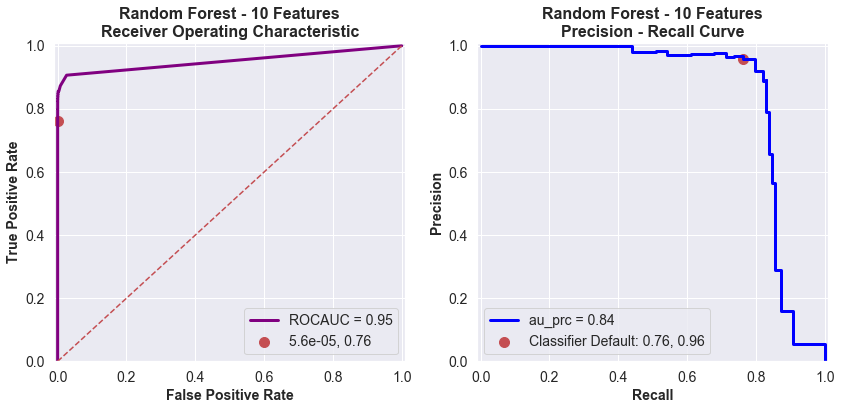

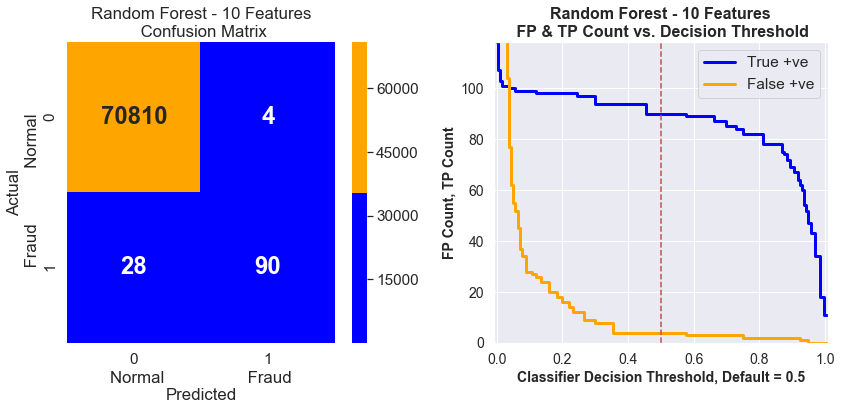

In [34]:
y_pred, probs, F1_Score = GetResults('Random Forest - 10 Features', RFC_model_10, x_test_10, y_test_10, Ps, Ns, 2)

## Run RandomSearch on the reduced feature set and see if the performance improves.

In [58]:
params={'n_estimators':[140, 150, 160], 'max_depth':[40, 50, 60],'criterion':['gini', 'entropy']}

model = RandomForestClassifier(random_state = 6)
clf = RandomizedSearchCV(model, param_distributions=params, n_iter=10, cv=2, scoring = 'f1', verbose=1, return_train_score=True)

clf.fit(x_train_10, y_train_10)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 17.3min finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [59]:
clf.best_params_

{'n_estimators': 160, 'max_depth': 40, 'criterion': 'entropy'}

model parameters:  {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 40, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 160, 'n_jobs': None, 'oob_score': False, 'random_state': 6, 'verbose': 0, 'warm_start': False}

Random Forest - 10 Features gives AU_PRC of 0.840and F1 Score of 0.849



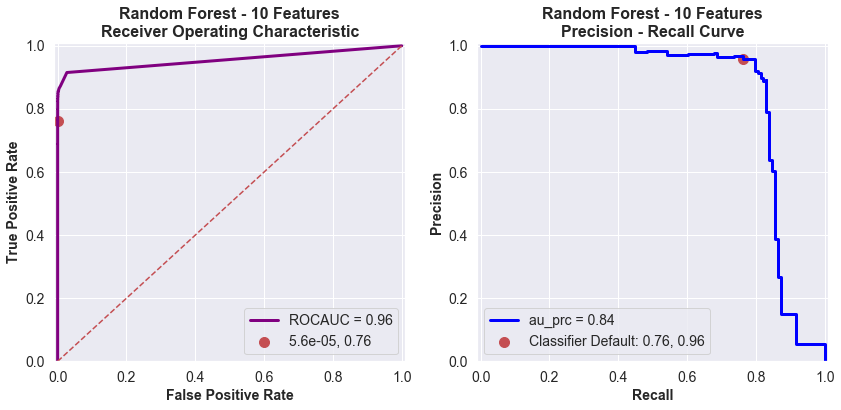

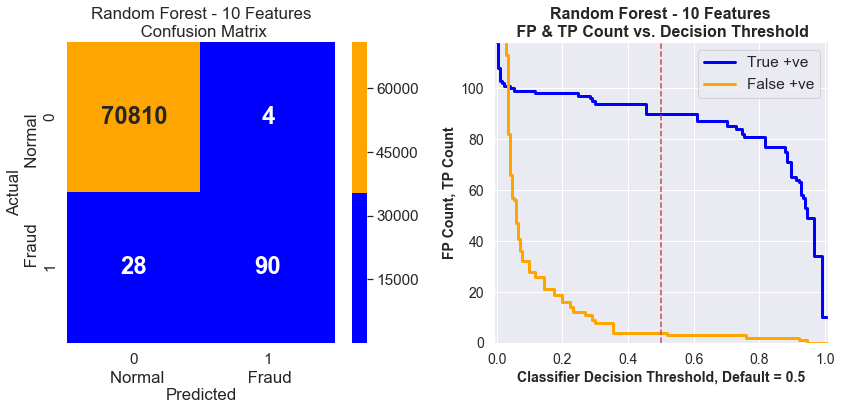

In [60]:
RFC_10_Opt_model = clf.best_estimator_
y_pred, probs, F1_Score = GetResults('Random Forest - 10 Features', US_RFC_Opt_model, x_test_10, y_test_10, Ps, Ns, 0)

In [61]:
fpr_, tpr_, thresholds_ = roc_curve(y_test, probs[:,1])
FP_TP_Count_Table('Random Forest - 10 Features', fpr_, tpr_, thresholds_, Ps, Ns, 25)

    ROC Curve TP & FP Count by Classifier Decision Threshold:    
                   Random Forest - 10 Features                   

-----------------------------------------------------------------
    i   Threshold       TPR      TP Count      FPR       FP Count
-----------------------------------------------------------------
    0       2.000       0.000         0.0     0.0e+00         0.0
    1       1.000       0.085        10.0     0.0e+00         0.0
    2       0.981       0.288        34.0     0.0e+00         0.0
    3       0.950       0.415        49.0     0.0e+00         0.0
    4       0.944       0.449        53.0     1.4e-05         1.0
    5       0.938       0.483        57.0     1.4e-05         1.0
    6       0.931       0.492        58.0     1.4e-05         1.0
    7       0.925       0.534        63.0     1.4e-05         1.0
    8       0.919       0.542        64.0     2.8e-05         2.0
    9       0.906       0.551        65.0     2.8e-05         2.0
   10    

### A decision threshold of 0.4 would increase the TP's to 94 while maintaining the FP's at 4 and improve the recall to 0.797 and improve the precision by a marginal amount. 

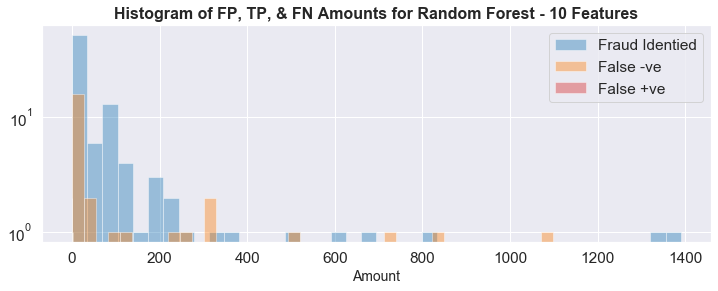

Fraud total identified is 9667.49,
Fraud total missed is 4659.40,
Normal total misclassified is 4.28


In [62]:
Det_Amt_PLot('Random Forest - 10 Features', Test_Set_10, y_test_10, y_pred)

### Performance is essentially the same as with all features.  AU_PRC dropped by 0.02 and fraud detection dropped by 1%.

### First: Re-Optimize the MLP as the features are significantly different.  Drop the poorest performing activation & solvers from the prior run in Part A

In [53]:
params={'hidden_layer_sizes':[70,80,90,100,110], 'activation':['tanh','relu'],'solver':['lbfgs','sgd','adam']}

model =  MLPClassifier(batch_size = 1000, max_iter = 200,random_state = 6)
clf = RandomizedSearchCV(model, param_distributions=params, n_iter=10, cv=3, verbose=2, scoring = 'f1', return_train_score=True)

clf.fit(x_train_10, y_train_10)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] solver=adam, hidden_layer_sizes=80, activation=tanh .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  solver=adam, hidden_layer_sizes=80, activation=tanh, total=   4.7s
[CV] solver=adam, hidden_layer_sizes=80, activation=tanh .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV]  solver=adam, hidden_layer_sizes=80, activation=tanh, total=   4.9s
[CV] solver=adam, hidden_layer_sizes=80, activation=tanh .............
[CV]  solver=adam, hidden_layer_sizes=80, activation=tanh, total=   5.8s
[CV] solver=adam, hidden_layer_sizes=110, activation=relu ............
[CV]  solver=adam, hidden_layer_sizes=110, activation=relu, total=  12.1s
[CV] solver=adam, hidden_layer_sizes=110, activation=relu ............
[CV]  solver=adam, hidden_layer_sizes=110, activation=relu, total=  10.1s
[CV] solver=adam, hidden_layer_sizes=110, activation=relu ............
[CV]  solver=adam, hidden_layer_sizes=110, activation=relu, total=  16.4s
[CV] solver=adam, hidden_layer_sizes=110, activation=tanh ............
[CV]  solver=adam, hidden_layer_sizes=110, activation=tanh, total=   8.0s
[CV] solver=adam, hidden_layer_sizes=110, activation=tanh ............
[CV]  solver=adam, hidden_layer_sizes=110, activation=tanh, total=   6.0s
[CV] solver=adam, hidden_layer_sizes=110, activation=tanh 

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  5.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size=1000, beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_iter=200, momentum=0.9,
                                           n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           random_state=6, shuffle=True,
                                           solver='adam', tol=0.0001,
                                           validation_fraction=0.1,
                      

In [54]:
clf.best_params_

{'solver': 'adam', 'hidden_layer_sizes': 90, 'activation': 'tanh'}

model parameters:  {'activation': 'tanh', 'alpha': 0.0001, 'batch_size': 1000, 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': 90, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 6, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}

Random Forest - 10 Features gives AU_PRC of 0.824and F1 Score of 0.830



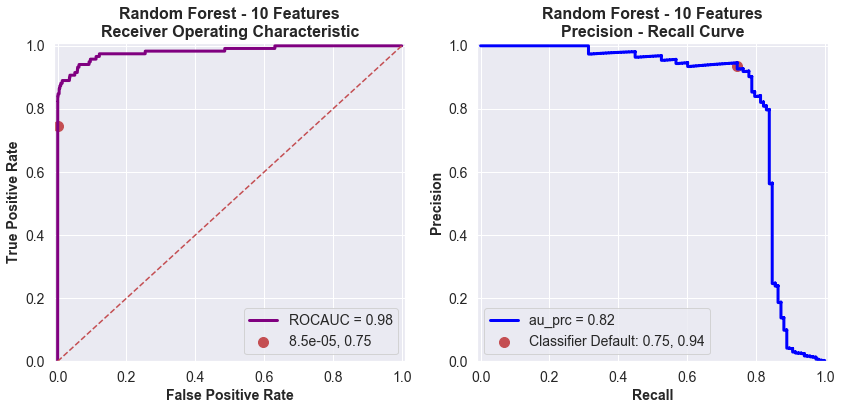

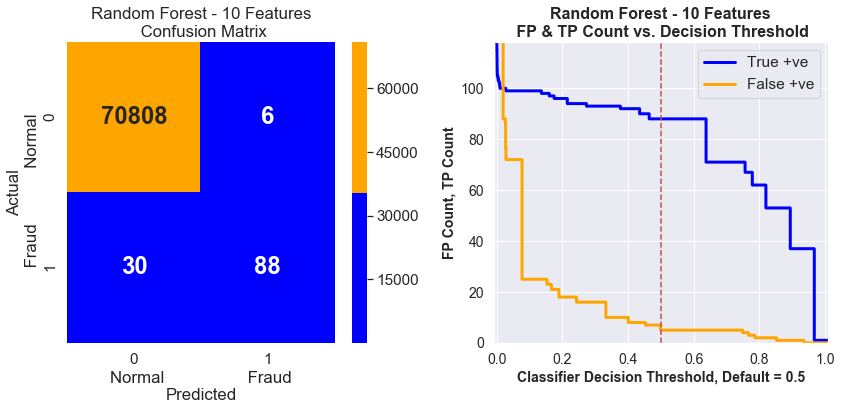

In [55]:
MLP_10_Opt_model = clf.best_estimator_
y_pred, probs, F1_Score = GetResults('Random Forest - 10 Features', MLP_10_Opt_model, x_test_10, y_test_10, Ps, Ns, 0)

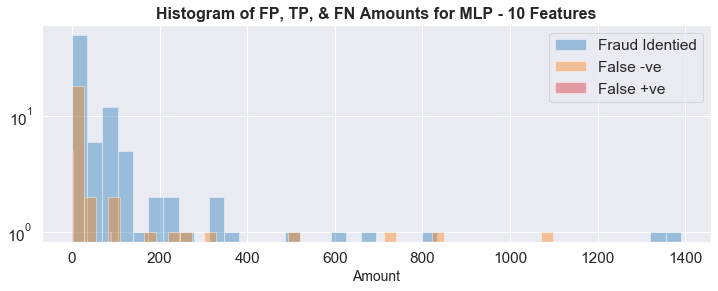

Fraud total identified is 9816.55,
Fraud total missed is 4510.34,
Normal total misclassified is 95.04


In [56]:
Det_Amt_PLot('MLP - 10 Features', Test_Set_10, y_test_10, y_pred)

### For MPL, AU_PRC & fraud amount detected dropped slightly (~ 2%) vs. using all features. 

### Performance dropped slightly for both classifiers vs. using all features.

# *Under Sampling*

### Drop the majority of the normal samples and create a more balanced dataset.  Target 10% of normal transactions. 

### First sample 28324 normal transactions into a normal df, then extract frauds, merge the two sets, shuffle & re-index.  Then it is ready to split into x & y and train_test_split.

In [63]:
# Get an undersample dataset
from sklearn.utils import shuffle
df_normal = df[df['class'] == 0].sample(n = 28324)
df_fraud = df[df['class'] == 1]
df_under = pd.merge(df_normal, df_fraud, how = 'outer')
df_under = shuffle(df_under)
df_under.index = range(df_under.shape[0])
df_under['class'].value_counts()

False    28324
True       473
Name: class, dtype: int64

In [64]:
# Split into x & y and train & test sets
y_under = df_under['class']
x_under = df_under.drop(['time', 'class'], axis = 1)
x_train_u, x_test_u, y_train_u, y_test_u = train_test_split(x_under, y_under, stratify = y_under, test_size = 0.25, random_state = 6)

In [65]:
# Reserve x_test amounts before scaling and get fraud & normal totals in x_test
Test_Set_U = x_test_u
x_u_fraud_total = x_test_u['amount'][y_test_u == 1].sum()
x_u_normal_total =x_test_u['amount'][y_test_u == 0].sum()
print(('Undersample Totals are Fraud: {:,.0f}, and Normal: {:,.0f}').format(x_u_fraud_total, x_u_normal_total))

Undersample Totals are Fraud: 12,602, and Normal: 590,245


In [66]:
# Get normal & fraud counts Nu & Pu for the test set
Nu, Pu = y_test_u.value_counts()
print(('Nu: {}  Pu   {}').format(Nu, Pu))

Nu: 7082  Pu   118


In [67]:
# Scale x_train  & x_test
scaler = StandardScaler()
x_train_u = scaler.fit_transform(x_train_u)
x_test_u = scaler.transform(x_test_u)

In [68]:
y_train_u = y_train_u.apply(lambda x: 0 if x == False else 1)
y_test_u = y_test_u.apply(lambda x: 0 if x == False else 1)

## Optimize using Random Search.

In [75]:
params={'n_estimators':[50, 75, 100, 125, 150, 200, 250, 500], 'max_depth':[10, 20, 25, 30, 40, 50],'criterion':['gini', 'entropy']}

model = RandomForestClassifier(random_state = 6)
clf = RandomizedSearchCV(model, param_distributions=params, n_iter=30, cv=3, verbose=1, return_train_score=True)

clf.fit(x_train_u, y_train_u)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 14.6min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [76]:
clf.best_params_

{'n_estimators': 250, 'max_depth': 40, 'criterion': 'gini'}

model parameters:  {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 40, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 250, 'n_jobs': None, 'oob_score': False, 'random_state': 6, 'verbose': 0, 'warm_start': False}

Random Forest - Under Sampling gives AU_PRC of 0.856and F1 Score of 0.852



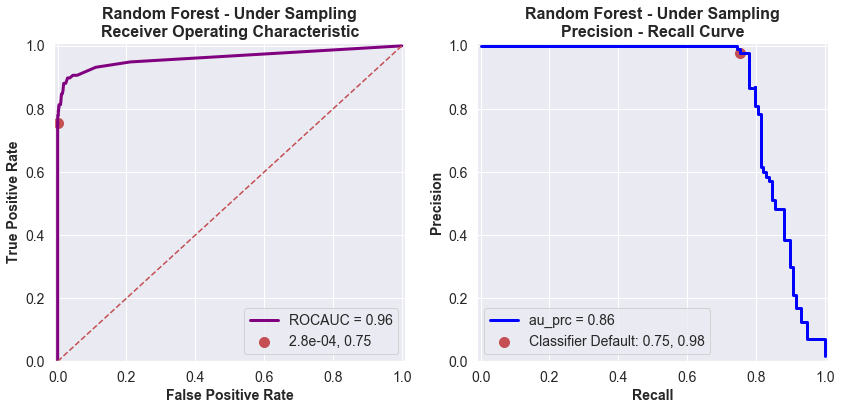

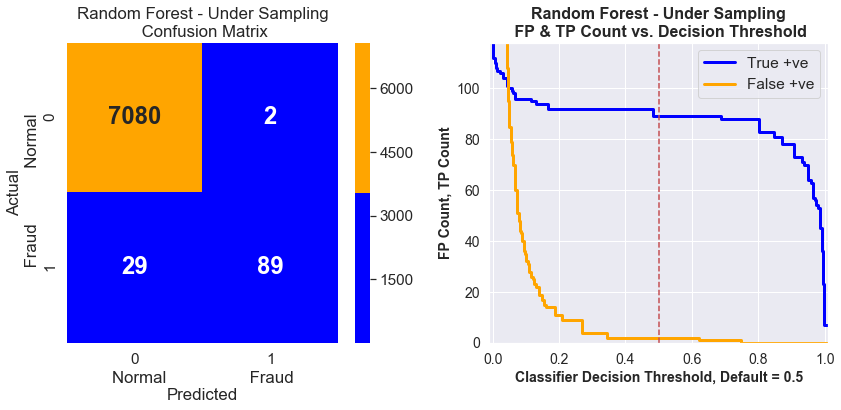

In [77]:
US_RFC_model = clf.best_estimator_
y_pred, probs, F1_Score = GetResults('Random Forest - Under Sampling', US_RFC_model, x_test_u, y_test_u, Pu, Nu, 0)

##  Now apply the model to the original size test set and see the results before calibrating the probabilities and decision thresholds.

 

Random Forest - Undersampling gives AU_PRC of 0.819and F1 Score of 0.453



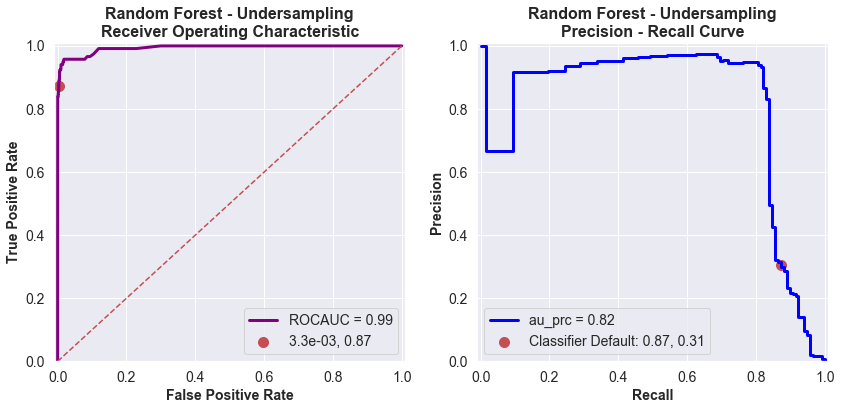

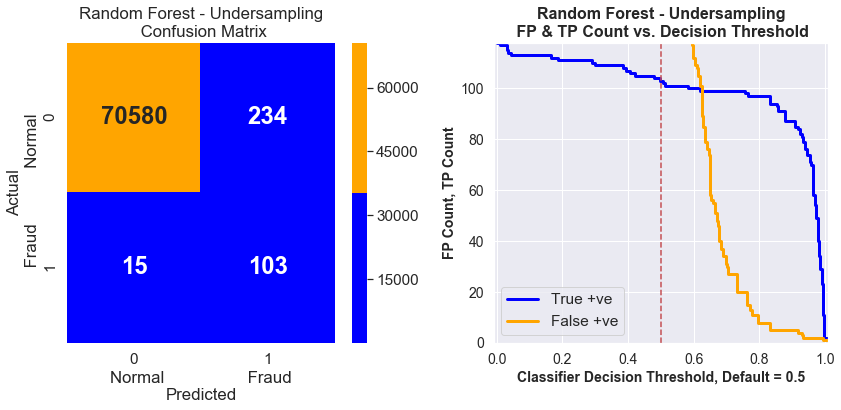

In [79]:
y_pred, probs, F1_Score = GetResults('Random Forest - Undersampling', US_RFC_model, x_test, y_test, P, N, 2)

In [82]:
fpr_, tpr_, thresholds_ = roc_curve(y_test, probs[:,1])
FP_TP_Count_Table('Random Forest - Undersampling', fpr_, tpr_, thresholds_, Ps, Ns, 30)

    ROC Curve TP & FP Count by Classifier Decision Threshold:    
                  Random Forest - Undersampling                  

-----------------------------------------------------------------
    i   Threshold       TPR      TP Count      FPR       FP Count
-----------------------------------------------------------------
    0       2.000       0.000         0.0     0.0e+00         0.0
    1       1.000       0.017         2.0     1.4e-05         1.0
    2       0.996       0.093        11.0     1.4e-05         1.0
    3       0.992       0.195        23.0     2.8e-05         2.0
    4       0.988       0.246        29.0     2.8e-05         2.0
    5       0.984       0.288        34.0     2.8e-05         2.0
    6       0.980       0.339        40.0     2.8e-05         2.0
    7       0.976       0.415        49.0     2.8e-05         2.0
    8       0.972       0.458        54.0     2.8e-05         2.0
    9       0.968       0.492        58.0     2.8e-05         2.0
   10    

## Now calibrate the probabilities and decision threshold  using eqn (9) as proposed by Dal Pozzolo et al: Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015
p' = Bps/ (Bps - ps +1), B = Ns-/N-, Here B = 28324/283253  The decision threshold before adjustment taken from the table above should be 0.81.

In [83]:
def Calib_Probs_Preds(Probs, Nu, N, DT):
    Beta = Nu/N
    #Calibrated Probabilities and adjusted decision threshold

    if DT != 0.5:
        ADT = (DT * Nu/N)/((DT * Nu/N) - DT + 1)
    else:
        ADT = 0.5

    Probs_calibrated = (Beta*Probs)/((Beta*Probs) - Probs + 1)

    Preds = np.empty((Probs.shape[0],1))
    Preds[:,0] = Probs_calibrated[:,1]>ADT

    return Probs_calibrated, Preds, ADT

In [84]:
#Calibrated predictions and probabilities
calib_probs, calib_preds, ADT = Calib_Probs_Preds(probs, Nu, N, 0.81)
calib_probs.shape, calib_preds.shape, ADT, probs.shape, N

((70932, 2), (70932, 1), 0.29891074394979344, (70932, 2), 70814)

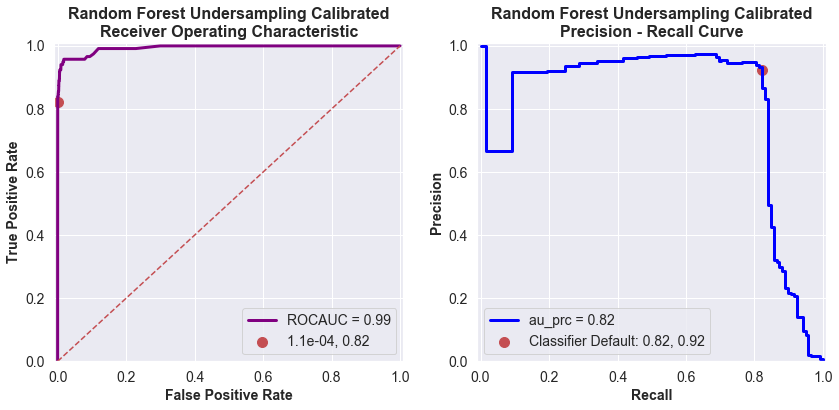

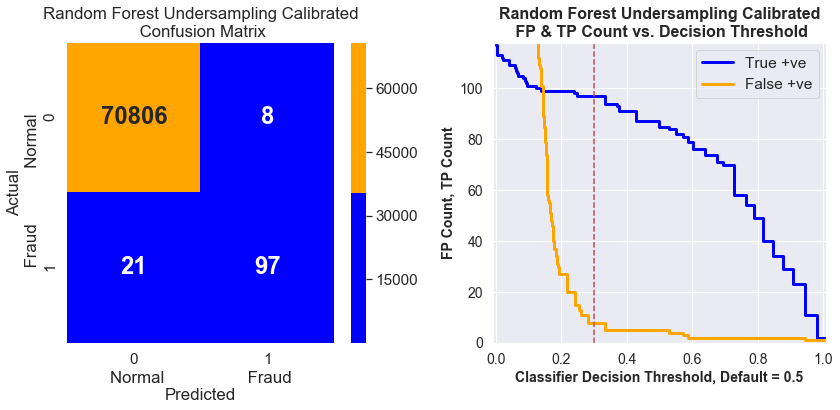

In [96]:
cm = confusion_matrix(y_test, calib_preds)
ROC_Pre_Count_Plots('Random Forest Undersampling Calibrated', y_test, calib_preds, calib_probs, cm, P, N, ADT)

In [90]:
print(('F1 Score is {:.3f}').format(f1_score(y_test,calib_preds)))

F1 Score is 0.870


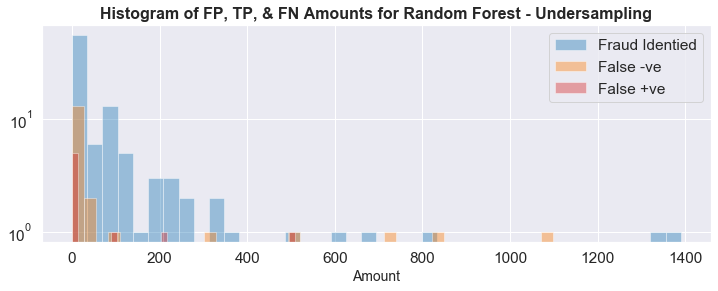

Fraud total identified is 10619.93,
Fraud total missed is 3706.96,
Normal total misclassified is 807.30


In [92]:
Det_Amt_PLot('Random Forest - Undersampling', Test_Set_10, y_test_10, calib_preds)

### *Observation: Compared to Random forest fitted on the full training set, the adjusted undersampled results have the same ROC score, a lower AU-PRC at (0.82 vs. 0.86) but a higher F1 Score (0.87 vs. 0.86). However, the F1 Score would be lower at a higher decision corresponding to the same false positive rate of 4.  Additionally, the model run on the full train set has a better True positive vs. decision threshold curve.  This model did identify a higher amount of frauds (~ 900.00) but also higher false positives (~ 800.00).   Ranking of Undersampling vs. using all samples would depend on the credit card company's preferences. 

### Another undersampling ratio may give better results.

## Optimize the MLP Classifier with the unndersampled dataset.

In [101]:
params={'hidden_layer_sizes':[10, 20, 30, 40, 50, 60, 80, 100, 120], 'activation':['tanh','logistic','relu'],'solver':['lbfgs','sgd','adam']}

model =  MLPClassifier(batch_size = 1000, max_iter = 200,random_state = 6)
clf = RandomizedSearchCV(model, param_distributions=params, n_iter=20, cv=3, verbose=1, return_train_score=True)

clf.fit(x_train_u, y_train_u)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.7min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size=1000, beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_iter=200, momentum=0.9,
                                           n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           random...
                                           solver='adam', tol=0.0001,
                                           validation_fraction=0.1,
                                          

In [102]:
clf.best_params_

{'solver': 'adam', 'hidden_layer_sizes': 100, 'activation': 'relu'}

model parameters:  {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 1000, 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 6, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}

MLP - Undersampling gives AU_PRC of 0.845and F1 Score of 0.854



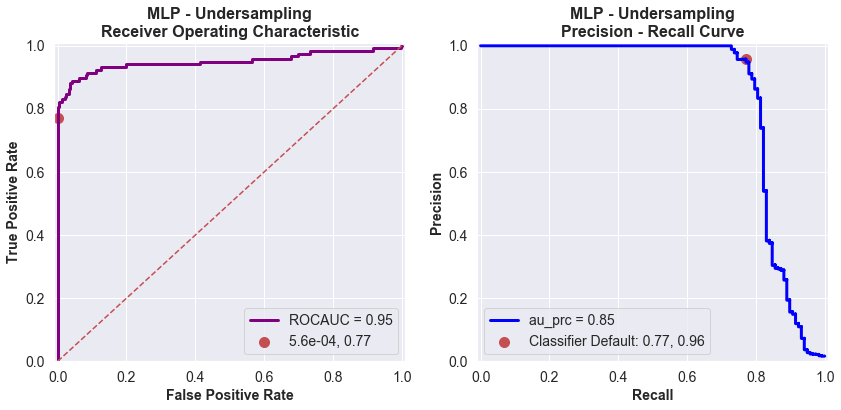

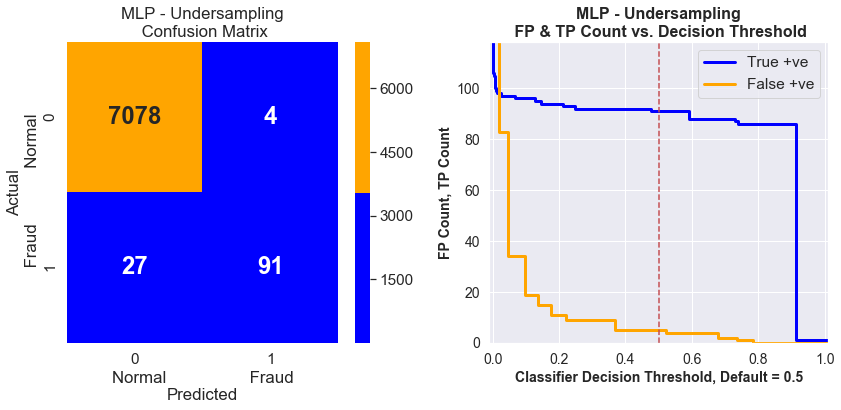

In [103]:
US_MLP_model = clf.best_estimator_
y_pred, probs, F1_Score = GetResults('MLP - Undersampling', US_MLP_model, x_test_u, y_test_u, Pu, Nu, 0, 0.5)

##  Now apply the model to the original size test set and see the results before calibrating the probabilities and decision thresholds.

 

MLP - Undersampling gives AU_PRC of 0.879and F1 Score of 0.712



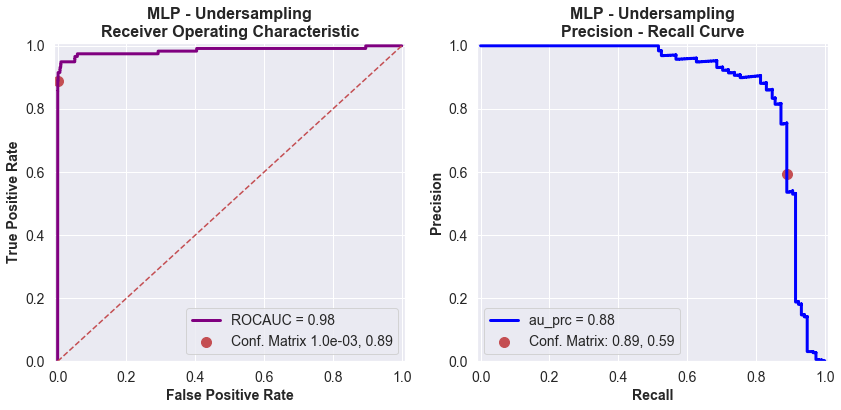

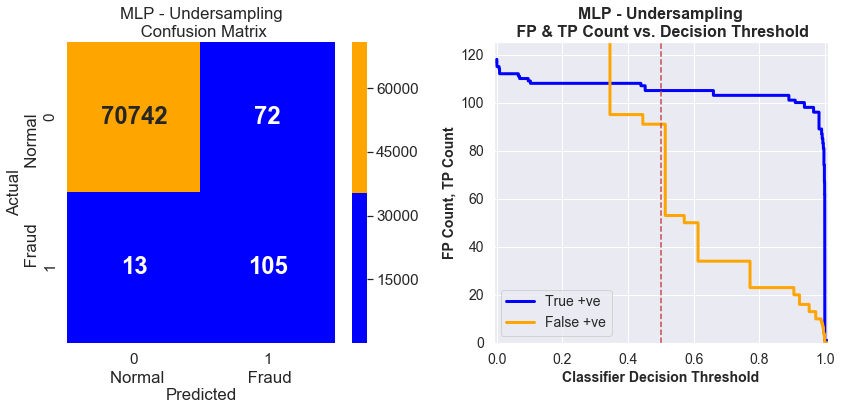

In [145]:
y_pred, probs, F1_Score = GetResults('MLP - Undersampling', US_MLP_model, x_test, y_test, P, N, 2, 0.5)

In [146]:
fpr_, tpr_, thresholds_ = roc_curve(y_test, probs[:,1])
FP_TP_Count_Table('MLP - Undersampling', fpr_, tpr_, thresholds_, Ps, Ns, 30)

    ROC Curve TP & FP Count by Classifier Decision Threshold:    
                       MLP - Undersampling                       

-----------------------------------------------------------------
    i   Threshold       TPR      TP Count      FPR       FP Count
-----------------------------------------------------------------
    0       2.000       0.000         0.0     0.0e+00         0.0
    1       1.000       0.008         1.0     0.0e+00         0.0
    2       1.000       0.517        61.0     0.0e+00         0.0
    3       1.000       0.517        61.0     1.4e-05         1.0
    4       1.000       0.525        62.0     1.4e-05         1.0
    5       0.999       0.525        62.0     2.8e-05         2.0
    6       0.999       0.568        67.0     2.8e-05         2.0
    7       0.999       0.568        67.0     4.2e-05         3.0
    8       0.998       0.627        74.0     4.2e-05         3.0
    9       0.998       0.627        74.0     5.6e-05         4.0
   10    

## Now calibrate the probabilities and decision threshold.

p' = Bps/ (Bps - ps +1), B = Ns-/N-, Here B = 28324/283253  The decision threshold before adjustment taken from the table above should be 0.972.

In [147]:
#Calibrated predictions and probabilities
calib_probs, calib_preds, ADT = Calib_Probs_Preds(probs, Nu, N, 0.975)
calib_probs.shape, calib_preds.shape, ADT, probs.shape, N

((70932, 2), (70932, 1), 0.7959321291482712, (70932, 2), 70814)

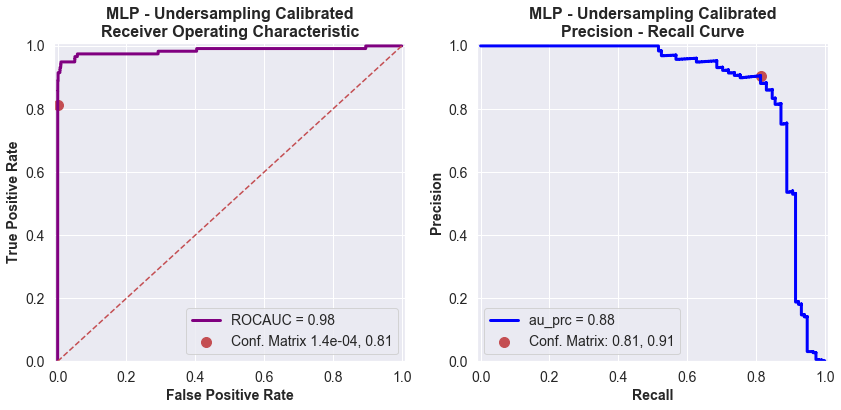

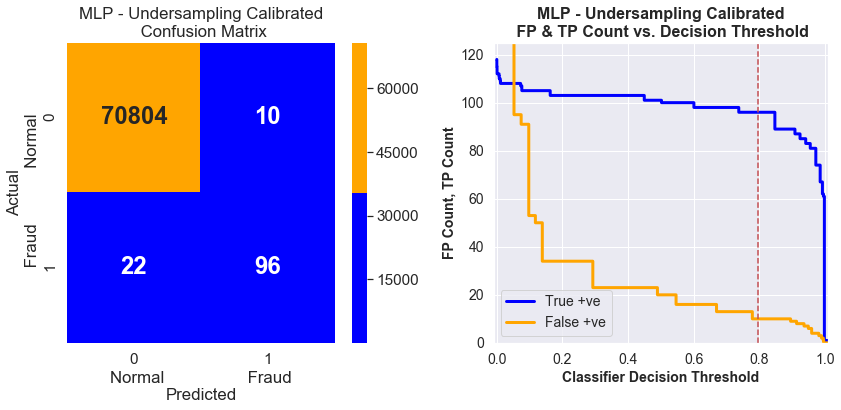

In [148]:
cm = confusion_matrix(y_test, calib_preds)
ROC_Pre_Count_Plots('MLP - Undersampling Calibrated', y_test, calib_preds, calib_probs, cm, P, N, ADT)

In [149]:
print(('F1 Score is {:.3f}').format(f1_score(y_test,calib_preds)))

F1 Score is 0.857


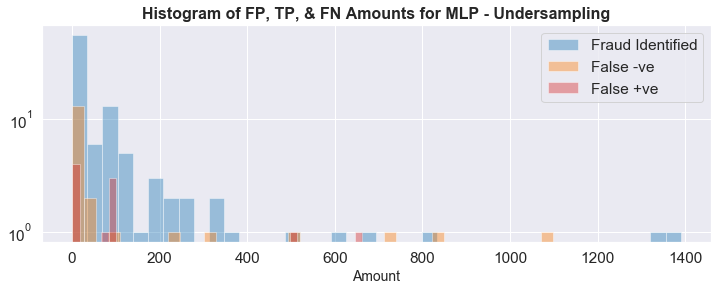

Fraud total identified is 10374.33,
Fraud total missed is 3952.56,
Normal total misclassified is 1519.81


In [150]:
Det_Amt_PLot('MLP - Undersampling', Test_Set_10, y_test_10, calib_preds)

### The calibrated results for Random Forest and MLP using Undersampling are similar but the adjusted decision threshold at ~0.3 for RF and 0.8 for MLP.  They have different characteristics.  Random Forest has a lower AU-PRC score which is driven by a single false positives with a very high probability corresponding to the first two true posititves.  The precision suffers, then rebounds as more TP's are identified at the next threshold (11 TP vs 1 FP). Since this part of the curve is not relevant, I would judge the Random Forest model as being better.

## Autoencoders are continued in Part 3